In [216]:
import pandas as pd
import numpy as np
import urllib
import bs4 as bs
from tqdm import tqdm
import time
import mysql.connector
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pickle
import joblib
from sklearn.pipeline import Pipeline



**********************
**Ajout des journaux en BDD**
**********************

In [217]:
def fill_db_journaux():
    cnx = mysql.connector.connect(user='vincent', password= 'coucou22', database='projetjournaux')
    cursor = cnx.cursor()
    sql = "INSERT IGNORE INTO journal (nom, parution) VALUES (%s, %s)"
    val = [("Le Monde", "quotidien"), ("Allocine", "quotidien")]
    cursor.executemany(sql, val)
    cnx.commit()
    cursor.close()
    cnx.close()
    
# fill_db_journaux()

**********************
**Execution MySQL**
**********************

In [218]:
def executeScriptsFromFile(file_name):
    cnx = mysql.connector.connect(user='vincent', password= 'coucou22')
    cursor = cnx.cursor()
    fd = open(file_name, 'r')
    sqlFile = fd.read()
    fd.close()
    sqlCommands = sqlFile.split(';')
    for command in sqlCommands:
        try:
            if command.strip() != '':
                cursor.execute(command)
        except IOError as msg: 
            print ("Command skipped: ", msg)
            
file_name ='MySQL.sql'
# executeScriptsFromFile(file_name)

************

In [219]:
def get_page(url):
    req = urllib.request.Request(url)
    html = urllib.request.urlopen(req).read()
    return bs.BeautifulSoup(html, "lxml")

**********************
**LE MONDE**
**********************

In [220]:
def get_summary_lemonde(page):
    summary = []
    print('Récupération des sommaires :')
    for item in tqdm(page.findAll('div', {'class': "wrapper"})):
        name = item.find("a").get('href')
        name = name[1:]
        summary.append(name)
    summary = summary[2:]
    print('-------------- fin du process get_summary_lemonde --------------')
    return summary

In [221]:
def get_articles_lemonde(summary, url):
    data = []
    list_of_url = []
    print('Récupération des URL :')
    print('')
    for item in summary:
        url_summary = url + item
        list_of_url.append(url_summary)
    print('Récupération des articles :')
    print('')
    for url in tqdm(list_of_url):
        page = get_page(url)
        for item in page.findAll('div', {'class': "thread"}):
            name = item.find("a").get('href')
            data.append(name)
    print('longueur des data articles : ',len(data))
    print('-------------- fin du process get_articles --------------')
    return data

In [222]:
def article_to_db_lemonde(list_of_article):
    data=[]
    print('-------------------------------------')
    print('Création des articles (titres, content, auteur): ')
    print('-------------------------------------')
    for url in tqdm(list_of_article):
        page = get_page(url)
        text = ''
        article=[]
        for title in page.findAll('h1', {'class': "article__title"}):
            article.append(title.getText())
        for content in page.findAll('p', {'class': "article__paragraph"}):
            t = content.getText()
            text += t
        if len(article) ==0:
            continue
        else : 
            article.append(text)
            if len(article) == 2:    
                data.append(article)
    return data

In [223]:
def fill_db_lemonde(data_lemonde):
    """
    Fonction servant à inseré dans la BDD les données relatif au journal 'Le Monde'.
    """
    cnx = mysql.connector.connect(user='vincent', password= 'coucou22', database='projetjournaux')
    cursor = cnx.cursor()
    nom = "Le Monde"
    print('Insertion des articles de "Le Monde" en BDD')
    print('-------------------------------------------')
    for i in tqdm(data_lemonde):
        res_article=[]
        if len(i)<2:
            titre = 'non renseigné'
            content = i
        else :
            titre = i[0]
            content = i[1] 
        if len(content)>1:
            res_article.append((titre, content, nom))
            cursor.executemany("INSERT IGNORE INTO articles VALUES (%s,%s,%s)", res_article)
        else :
            # print("article ", i[0], "non rajouté")
            continue
    cnx.commit()
    cursor.close()
    cnx.close()

In [224]:
def scrap_lemonde():
    print('----------------------')
    print('Début du traitement : ')
    print('----------------------')
    temps1=time.time()
    url = 'https://www.lemonde.fr/'
    page = get_page(url)
    summary = get_summary_lemonde(page)
    list_of_article = get_articles_lemonde(summary, url)
    data = article_to_db_lemonde(list_of_article)
    fill_db_lemonde(data)
    duration1=time.time()-temps1
    print("Temps de traitement pour l'ajout en BDD des articles 'Le Monde' : ", "%15.2f" % duration1, "secondes")
    
# scrap_lemonde()

**********************
**ALLOCINE**
**********************

In [225]:
def get_articles_allocine(summary):
    url = 'https://www.allocine.fr'
    data = []
    list_of_url = []
    print('Récupération des URL :')
    print('')
    for item in summary:
        url_summary = url + item
        list_of_url.append(url_summary)
    # print(list_of_url)
    print('Récupération des articles :')
    print('')
    for url in tqdm(list_of_url):
        page = get_page(url)
        for item in page.findAll('h2', {'class': "meta-title"}):
            name = item.find("a").get('href')
            data.append(name)
    print('longueur des data articles : ',len(data))
    print('-------------- fin du process get_articles --------------')
    return data

In [226]:
def get_summary_allocine(page):
    summary = []
    print('Récupération des sommaires :')
    for item in tqdm(page.findAll('li', {'class': "header-subnav-item"})):
        try :
            children = item.findChildren("a" , recursive=False)
            for child in children:
                res = child.get('href')
                summary.append(res)       
        except:
            print('------------------------------------')
            print("An exception occurred for ", item) 
            pass
    list_of_exception = ['/news/cinema/', '/news/series/', '/film/court-metrage/news/', '/podcast/']
    for url in list_of_exception:
        summary.append(url) 
    print(summary)
    print('-------------- fin du process get_summary_allocine --------------')
    return summary

In [227]:
def article_to_db_allocine(list_of_article):
    data=[]
    print('-------------------------------------')
    print('Création des articles (titres, content, auteur): ')
    print('-------------------------------------')
    for url in tqdm(list_of_article):
        url = 'https://www.allocine.fr' + url
        page = get_page(url)
        text = ''
        article=[]
        for title in page.findAll('div', {'class': "titlebar-title titlebar-title-lg"}):
            article.append(title.getText())
        for content in page.findAll('p'):
            t = content.getText()
            text += t
        if len(article) ==0:
            continue
        else : 
            article.append(text)
            if len(article) == 2:    
                data.append(article)
    return data

In [228]:
def fill_db_allocine(data_allocine):
    """
    Fonction servant à inseré dans la BDD les données relatif au site 'Allocine'.
    """
    try:
        cnx = mysql.connector.connect(user='vincent', password= 'coucou22', database='projetjournaux')
        cursor = cnx.cursor()
    except Exception as e:
        cursor.close()
        cnx.close()
        print(str(e))
    nom = "Allocine"
    print('Insertion des articles de "Allocine" en BDD')
    print('-------------------------------------------')
    for i in tqdm(data_allocine):
        res_article=[]
        if len(i)<2:
            titre = 'non renseigné'
            content = i
        else :
            titre = i[0]
            content = i[1] 
        if len(content)>1:
            res_article.append((titre, content, nom))
            cursor.executemany("INSERT IGNORE INTO articles VALUES (%s,%s,%s)", res_article)
        else :
            # print("article ", i[0], "non rajouté")
            continue
    cnx.commit()
    cursor.close()
    cnx.close()

In [229]:
def scrap_allocine():
    url = 'https://www.allocine.fr/news/'
    page = get_page(url)
    summary = get_summary_allocine(page)
    list_of_article = get_articles_allocine(summary)
    data = article_to_db_allocine(list_of_article)
    fill_db_allocine(data)
    
    
# data_allocine = scrap_allocine()

**********************
**Création de la DF**
**********************

In [230]:
def make_df():
    try:
        cnx = mysql.connector.connect(user='vincent', password= 'coucou22', database='projetjournaux')
        query = "Select * from articles;"
        result_dataFrame = pd.read_sql(query,cnx)
        cnx.close() 
    except Exception as e:
        cnx.close()
        print(str(e))
    return result_dataFrame

In [231]:
filenamedf = 'data/result_dataFrame.sav'
df = pickle.load(open(filenamedf, 'rb'))

# df = make_df()

In [232]:
df.head()

,titre,content,journal
0,"A Loutsk, la hantise d’une attaque biélorusse","Un homme armé dans les escaliers, un autre dan...",Le Monde
1,Au moins huit morts dans le bombardement d’un ...,La puissance de la frappe a soufflé les véhicu...,Le Monde
2,« Il a fallu attendre l’agression déclenchée p...,Chronique. « Nous sommes convaincus que l’Euro...,Le Monde
3,Des manifestants polonais réclament l’interdic...,"Emmitouflé dans sa doudoune, Ivan Benesko se t...",Le Monde
4,Juger les crimes de guerre de Poutine,"Editorial du « Monde ». Pour Joe Biden, présid...",Le Monde


(1144, 3)
------------------------------------
titre      object
content    object
journal    object
dtype: object
------------------------------------
titre      0
content    0
journal    0
dtype: int64
------------------------------------


<AxesSubplot:>

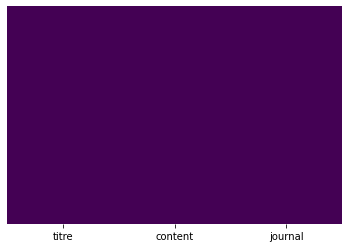

In [233]:
print(df.shape)
print('------------------------------------')
print(df.dtypes)
print('------------------------------------')
print(df.isna().sum())
print('------------------------------------')
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [234]:
def cleanContent(review_text):
    stop_words =stopwords.words('french')
    new_stopwords_to_add= ['allociné', '892', '000', 'cookies']
    stop_words.extend(new_stopwords_to_add)
    review_text = str(review_text).lower().strip()
    review_text = word_tokenize(review_text)
    review_text = [word for word in review_text if word not in stop_words]
    lemma=WordNetLemmatizer()
    review_text = [lemma.lemmatize(word=w, pos='v') for w in review_text]
    review_text = [w for w in review_text if len(w) > 2]
    review_text = ' '.join(review_text)
    return review_text

# Création de la nouvelle colonne
df['Clean_content'] = df.apply(lambda row: cleanContent(row['titre'] + ' ' + row['content']), axis=1)

In [235]:
df.head()

,titre,content,journal,Clean_content
0,"A Loutsk, la hantise d’une attaque biélorusse","Un homme armé dans les escaliers, un autre dan...",Le Monde,loutsk hantise attaque biélorusse homme armé e...
1,Au moins huit morts dans le bombardement d’un ...,La puissance de la frappe a soufflé les véhicu...,Le Monde,moins huit morts bombardement centre commercia...
2,« Il a fallu attendre l’agression déclenchée p...,Chronique. « Nous sommes convaincus que l’Euro...,Le Monde,fallu attendre agression déclenchée vladimir p...
3,Des manifestants polonais réclament l’interdic...,"Emmitouflé dans sa doudoune, Ivan Benesko se t...",Le Monde,manifestants polonais réclament interdiction c...
4,Juger les crimes de guerre de Poutine,"Editorial du « Monde ». Pour Joe Biden, présid...",Le Monde,juger crimes guerre poutine editorial monde jo...


(-0.5, 1499.5, 1199.5, -0.5)

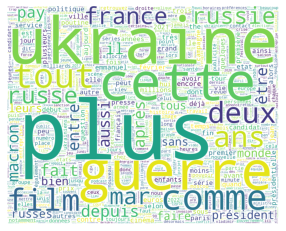

In [236]:
vectorizer = TfidfVectorizer()
corpus = df['Clean_content']
Tfidf = vectorizer.fit_transform(corpus)

tfidf_weights = [(word, Tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))

# plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
# plt.savefig('recipes_wordcloud.png')


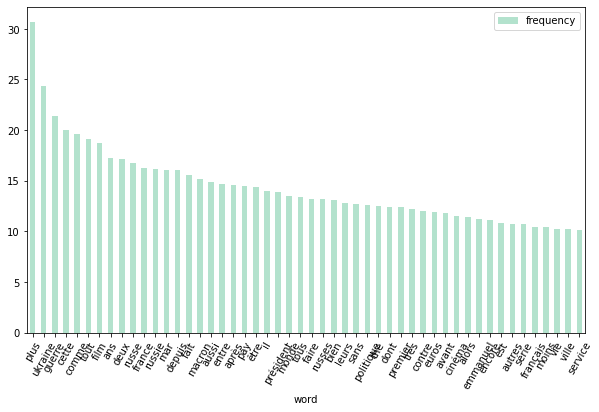

In [237]:
t=sorted(tfidf_weights, key=lambda tup: tup[1], reverse=True)
df1 = pd.DataFrame(t, columns=['word', 'frequency'])
df1.head(50).plot(kind='bar', x='word', colormap='Pastel2', figsize=(10, 6))
plt.xticks(rotation=60) 
plt.show()

In [238]:
df.head()

,titre,content,journal,Clean_content
0,"A Loutsk, la hantise d’une attaque biélorusse","Un homme armé dans les escaliers, un autre dan...",Le Monde,loutsk hantise attaque biélorusse homme armé e...
1,Au moins huit morts dans le bombardement d’un ...,La puissance de la frappe a soufflé les véhicu...,Le Monde,moins huit morts bombardement centre commercia...
2,« Il a fallu attendre l’agression déclenchée p...,Chronique. « Nous sommes convaincus que l’Euro...,Le Monde,fallu attendre agression déclenchée vladimir p...
3,Des manifestants polonais réclament l’interdic...,"Emmitouflé dans sa doudoune, Ivan Benesko se t...",Le Monde,manifestants polonais réclament interdiction c...
4,Juger les crimes de guerre de Poutine,"Editorial du « Monde ». Pour Joe Biden, présid...",Le Monde,juger crimes guerre poutine editorial monde jo...


In [239]:
# import pandas as pd
# import re
# import nltk
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# processed_text = df['Clean_content']
# y = df['journal']
# tfidfconverter = TfidfVectorizer(analyzer='word')
# tfidf_obj = tfidfconverter.fit_transform(processed_text)

# X_train, X_test, y_train, y_test = train_test_split(tfidf_obj, y, test_size=0.3, random_state=0)

# text_classifier = MLPClassifier()
# text_classifier.fit(X_train, y_train)

# predictions = text_classifier.predict(X_test)
# print(confusion_matrix(y_test, predictions))
# print(classification_report(y_test, predictions))
# print(accuracy_score(y_test, predictions))

In [240]:
processed_text = df['Clean_content']
y = df['journal']
tfidfconverter = TfidfVectorizer(analyzer='word')
tfidf_obj = tfidfconverter.fit_transform(processed_text).toarray()


X_train, X_test, y_train, y_test = train_test_split(tfidf_obj, y, test_size=0.3, random_state=0)

models = [MLPClassifier(), GaussianNB(), LinearSVC()]

scores = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append({
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, pos_label='Le Monde'),
        'precision': precision_score(y_test, y_pred, pos_label='Le Monde'),
        'recall': recall_score(y_test, y_pred, pos_label='Le Monde')
    })

df_scores = pd.DataFrame(scores, index=['MLP', 'GaussianNB', 'LinearSVC'])

In [241]:
df_scores

,accuracy,f1_score,precision,recall
MLP,0.985465,0.990758,0.981685,1.000000
GaussianNB,0.889535,0.933566,0.878289,0.996269
LinearSVC,0.997093,0.998138,0.996283,1.000000


**LinearSVC() valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose']**

In [242]:
# Paramètres de la grille de recherche
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['lbfgs', 'adam'],
}

# Modèle à utiliser
mlp = MLPClassifier()

# GridSearch avec validation croisée à 5
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3)

# Fit le GridSearch sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Affiche les meilleurs hyperparamètres et le score correspondant
print("Meilleurs hyperparamètres: ", grid_search.best_params_)
print("Meilleur score: ", grid_search.best_score_)


/home/vincent/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincent/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincent/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincent/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincent/.local/lib/python3.10/site-pac

Meilleurs hyperparamètres:  {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}
Meilleur score:  0.9899937108689326


In [264]:
# Initialisation du MLPClassifier avec les meilleurs hyperparamètres
estimator = grid_search.best_estimator_

pipeline = Pipeline([('tfidf',tfidfconverter), ('mlp',estimator)])

with open('estimator_model.pkl', 'wb') as f:
    joblib.dump(pipeline, f)

In [244]:

classifier = MLPClassifier().fit(X_train, y_train)

pipeline = Pipeline([('tfidf',tfidfconverter), ('mlp',classifier)])

with open('classifier_model.pkl', 'wb') as f:
    joblib.dump(pipeline, f)

In [245]:
test = ["Un goût amer. Emmanuel Macron a vivement dénoncé lundi 28 mars comme « une indignité » le fait qu'Éric Zemmour a laissé la foule scander « Macron assassin » sans réagir lors de son meeting au Trocadéro dimanche 27 mars, en conseillant au « candidat malentendant » de profiter de la réforme permettant le remboursement des prothèses auditives. « Il y a deux hypothèses : la première est l'indignité, c'est celle qui me semble la plus crédible, mais ce n'est pas une surprise », a déclaré le président candidat à son arrivée à Dijon pour une visite dans le cadre de la campagne pour la présidentielle. « La deuxième, c'est la méconnaissance d'une réforme très importante du quinquennat, c'est le 100 % santé. Maintenant, les prothèses auditives, les lunettes et les prothèses dentaires sont remboursées par la Sécurité sociale », a ajouté Emmanuel Macron. « Dix millions de Françaises et de Français y ont eu accès, cela fait partie de mon bilan et c'est un bilan social dont je suis fier. J'invite le candidat malentendant à pouvoir s'équiper à moindres frais. ». Des déclarations qui n'ont pas manqué de faire réagir Éric Zemmour dans la foulée sur BFM TV : « Il sait très bien ce qu'est un meeting, on n'entend pas tout ce qui se passe quand on est à la tribune. Ce sont des mauvais procès, on ne parle que d'une chose mineure […]. Ce ne sont pas des militants, ne mélangez pas les militants et spectateurs d'un meeting. On ne contrôle pas 100 000 personnes donc arrêtez de vous polariser volontairement sur un point mineur de ce meeting », a-t-il dit.",
        "Marvel en dévoile un peu plus sur son Doctor Strange in the Multiverse of Madness, grâce à de nouvelles photos.Alors que Spider-Man : No Way Home, le grand favori du prix des fans aux Oscars 2022, a été évincé par Zack Snyder et son Army of the Dead, Kevin Feige a dû être un peu déçu. Mais avec la Phase 4 déjà bien commencée, Marvel n'est toutefois pas près de perdre sa place de choix dans le coeur des fans (et du public tout court).Suite de Doctor Strange de Scott Derrickson, Doctor Strange in the Multiverse of Madness sera le cinquième film de la Phase 4 du MCU, initiée par Black Widow, et lancera la hype MCU au cinéma en 2022 (alors que Moon Knight s'occupera des séries dès le 30 mars). Le film se passera juste après les événements de Spider-Man : No Way Home, quelques jours-semaines après que le Sorcier a complètement détraqué le multivers.À en juger par la dernière bande-annonce de Doctor Strange in the Multiverse of Madness, il va falloir réparer tout ça. Et si tout le monde est sûrement plus à fond à l'idée de découvrir la bande-annonce de Avatar 2 lors de la sortie du film de Sam Raimi, Marvel a relancé la promotion de son Doctor Strange 2 avec des images de ses héros. Pour (encore) sauver le monde, Benedict Cumberbatch renfilera donc sa cape pour la sixième fois, mais il ne sera pas seul, son acolyte Wong, la puissante Wanda et la petite nouvelle America Chavez seront à ses côtés. Un trio qui devrait bien aider le Sorcier alors qu'il va sans doute devoir affronter de nombreuses entités dangereuses à travers les dimensions parallèles. Des antagonistes dont on ne connaît en revanche pas grand-chose.Alors qu'au niveau du casting, on sait que Chiwetel Ejiofor, Rachel McAdams et Michael Stuhlbarg seront aussi de la partie, et que Patrick Stewart, le célèbre professeur Xavier, devrait aussi être à l'affiche pour un rôle encore tenu secret, l'identité du méchant principal est encore très floue. Plusieurs méchants pourraient être dans Doctor Strange 2, mais difficile de savoir lequel sera le véritable ennemi de Stephen Strange, la promotion de Marvel n'en montrant pour le moment pas trop.",
        "Fabien Delrue et William Villeger (n°63 mondiaux) peuvent nourrir des regrets. Pour leur première apparition aux Championnats du monde, à Huelva (ESP), les deux Français ont été éliminés en huitièmes de finale par la paire japonaise Matsui-Takeuchi (n°43) 24-22, 25-23, après avoir eu deux volants de set dans la première manche, et un dans la deuxième. Delrue et Villeger s'étaient imposés au tour précédent face au duo britannique 17e mondial, Vendy-Lane (21-19, 12-21, 21-15).Déception également pour le double mixte. Exemptés du premier tour, vainqueurs des Danois Soby-Mikkelsen à la belle en 16es, Thom Gicquel et Delphine Delrue se sont inclinés ce jeudi face aux Japonais Matsutomo-Kaneko (n°18), 21-15, 21-16. En manque de compétition et de confiance en raison de la blessure de Thom Gicquel en octobre, les Français doivent en outre affronter des paires qui ont désormais étudié leur jeu. Giquel et Delrue vont désormais enchaîner sur une période d'entraînement.Tous les Français engagés en simple avaient été éliminés précédemment : Brice Leverdez et Qi Xuefei au premier tour, Thomas Rouxel et Marie Batomene au second.Les Mondiaux s'achèveront ce dimanche. ",
        "Pour un neuvième vol plané de chauve-souris, le Batman de Matt Reeves succède à celui de Tim Burton, Joel Schumacher ou Christopher Nolan avec cette fois Robert Pattinson dans le rôle-titre, Zoë Kravitz en Catwoman, Paul Dano très sphynx, Colin Farrell très pingouin, et même John Turturro. Trois heures pour suivre Bruce Wayne, alias Batman, dans son combat contre la corruption qui sévit à Gotham City. Tout cela en pleine campagne pour l'élection du nouveau maire et pour élucider les crimes du Sphinx. Un film où retentissent les plus grands troubles de l'époque : faillite démocratique, alerte terroriste, hantise de la catastrophe où gronde l'imminence d'un désastre…"]

In [246]:
titre = [cleanContent(test[0])]
titre

["goût amer emmanuel macron vivement dénoncé lundi mar comme indignité fait qu'éric zemmour laissé foule scander macron assassin sans réagir lors meet trocadéro dimanche mar conseillant candidat malentendant profiter réforme permettant remboursement prothèses auditives deux hypothèses première l'indignité c'est celle semble plus crédible n'est surprise déclaré président candidat arrivée dijon visite cadre campagne présidentielle deuxième c'est méconnaissance d'une réforme très importante quinquennat c'est 100 santé maintenant prothèses auditives lunettes prothèses dentaires remboursées sécurité sociale ajouté emmanuel macron dix millions françaises français accès cela fait partie bilan c'est bilan social dont fier j'invite candidat malentendant pouvoir s'équiper moindres frais déclarations n'ont manqué faire réagir éric zemmour foulée bfm sait très bien qu'est meet n'entend tout passe quand tribune mauvais procès parle d'une choose mineure militants mélangez militants spectateurs d'un 

In [247]:
with open('classifier_model.pkl', 'rb') as f:
    # Utiliser pickle pour lire l'objet depuis le fichier
    loaded_model = joblib.load(f)
    
loaded_model.predict(test)

array(['Le Monde', 'Allocine', 'Le Monde', 'Le Monde'], dtype='<U8')

In [248]:
a =' Dany Boon : cette illustre actrice est au casting de sa nouvelle comédie La Vie pour de vrai'
titre = [cleanContent(a)]
titre

['dany boon cette illustre actrice cast nouvelle comédie vie vrai']

In [249]:
loaded_model.predict(titre)

array(['Allocine'], dtype='<U8')

In [254]:
b = 'Réforme des retraites : Emmanuel Macron se donne « cent jours » pour agir « au service de la France »'
titre = [cleanContent(b)]
titre

['réforme retraites emmanuel macron donne cent jours agir service france']

In [255]:
loaded_model.predict(titre)

array(['Le Monde'], dtype='<U8')

In [268]:
loaded_model.predict_proba(titre)[0]

array([2.67215609e-06, 9.99997328e-01])

In [265]:
with open('estimator_model.pkl', 'rb') as f:
    # Utiliser pickle pour lire l'objet depuis le fichier
    loaded_model = joblib.load(f)
    
loaded_model.predict(titre)

array(['Le Monde'], dtype='<U8')

In [266]:
loaded_model.predict(test)

array(['Le Monde', 'Le Monde', 'Le Monde', 'Le Monde'], dtype='<U8')

***